# セマンティックセグメンテーションの推論

In [1]:
#パッケージのインポート
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models,transforms
import cv2 
import time
import math

/Users/kawadatakeshiho/opt/anaconda3/envs/My_Env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 推論

In [3]:
from make_datapath_listimport make_datapath_list

SyntaxError: invalid syntax (1706138299.py, line 1)

In [2]:
#from utils.dataloader import make_datapath_list, DataTransform
import make_datapath_list

#ファイルパスリストを作成
rootpath="../3_semantic_segmentation/data/VOCdevkit/VOC2012/"
train_img_list,train_anno_list,val_img_list,val_anno_list=make_datapath_list(rootpath=rootpath)

#後ほどアノテーション画像のみ使用する

In [4]:
train_img_list

['../3_semantic_segmentation/data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg',
 '../3_semantic_segmentation/data/VOCdevkit/VOC2012/JPEGImages/2007_000039.jpg',
 '../3_semantic_segmentation/data/VOCdevkit/VOC2012/JPEGImages/2007_000063.jpg',
 '../3_semantic_segmentation/data/VOCdevkit/VOC2012/JPEGImages/2007_000068.jpg',
 '../3_semantic_segmentation/data/VOCdevkit/VOC2012/JPEGImages/2007_000121.jpg',
 '../3_semantic_segmentation/data/VOCdevkit/VOC2012/JPEGImages/2007_000170.jpg',
 '../3_semantic_segmentation/data/VOCdevkit/VOC2012/JPEGImages/2007_000241.jpg',
 '../3_semantic_segmentation/data/VOCdevkit/VOC2012/JPEGImages/2007_000243.jpg',
 '../3_semantic_segmentation/data/VOCdevkit/VOC2012/JPEGImages/2007_000250.jpg',
 '../3_semantic_segmentation/data/VOCdevkit/VOC2012/JPEGImages/2007_000256.jpg',
 '../3_semantic_segmentation/data/VOCdevkit/VOC2012/JPEGImages/2007_000333.jpg',
 '../3_semantic_segmentation/data/VOCdevkit/VOC2012/JPEGImages/2007_000363.jpg',
 '../3_semantic_segmentation

In [3]:
train_anno_list

['../3_semantic_segmentation/data/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png',
 '../3_semantic_segmentation/data/VOCdevkit/VOC2012/SegmentationClass/2007_000039.png',
 '../3_semantic_segmentation/data/VOCdevkit/VOC2012/SegmentationClass/2007_000063.png',
 '../3_semantic_segmentation/data/VOCdevkit/VOC2012/SegmentationClass/2007_000068.png',
 '../3_semantic_segmentation/data/VOCdevkit/VOC2012/SegmentationClass/2007_000121.png',
 '../3_semantic_segmentation/data/VOCdevkit/VOC2012/SegmentationClass/2007_000170.png',
 '../3_semantic_segmentation/data/VOCdevkit/VOC2012/SegmentationClass/2007_000241.png',
 '../3_semantic_segmentation/data/VOCdevkit/VOC2012/SegmentationClass/2007_000243.png',
 '../3_semantic_segmentation/data/VOCdevkit/VOC2012/SegmentationClass/2007_000250.png',
 '../3_semantic_segmentation/data/VOCdevkit/VOC2012/SegmentationClass/2007_000256.png',
 '../3_semantic_segmentation/data/VOCdevkit/VOC2012/SegmentationClass/2007_000333.png',
 '../3_semantic_segmentation/dat

In [12]:
val_anno_list[0]

'../3_semantic_segmentation/data/VOCdevkit/VOC2012/SegmentationClass/2007_000033.png'

In [ ]:
#PSPNetの用意
from utils.pspnet import PSPNet

net=PSPNet(n_classes=21)

#学習済みパラメータをロード
state_dict=torch.load("../3_semantic_segmentation/weights/pspnet50_30.pth",map_location={"cuda:0":"cpu"})
net.load_state_dict(state_dict)

print("ネットワーク設定完了：学習済みの重みをロードしました")

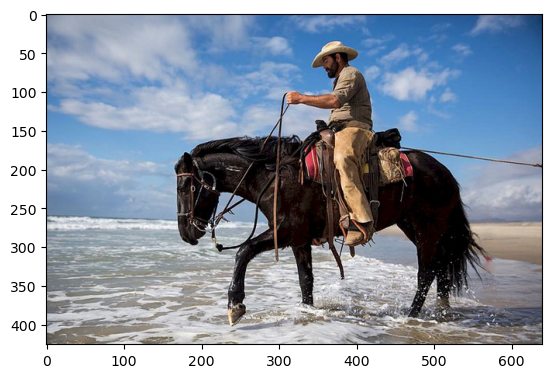

In [9]:
#1. 元画像の表示
image_file_path="../3_semantic_segmentation/data/cowboy-757575_640.jpg"
img=Image.open(image_file_path)
img_width,img_height=img.size
plt.imshow(img)
plt.show()

In [10]:
#2. 前処理クラスの作成
color_mean=(0.485,0.456,0.406)
color_std=(0.229,0.224,0.225)
transforms=DataTransform(input_size=475,color_mean=color_mean,color_std=color_std)

#3. 前処理
#適当なアノテーション画像を用意し、さらにカラーパレットの情報を抜き出す
anno_file_path=val_anno_list[0]
anno_class_img=Image.open(anno_file_path) #[高さ][幅]
p_palette=anno_class_img.getpalette()
phase="val"
img,anno_class_img=transforms(phase,img,anno_class_img)


In [7]:
val_anno_list[0]

'../3_semantic_segmentation/data/VOCdevkit/VOC2012/SegmentationClass/2007_000033.png'

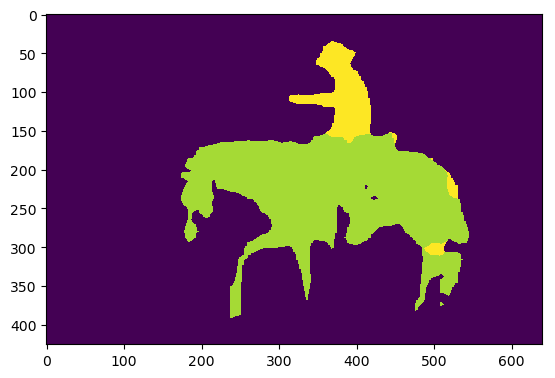

In [9]:
#4. PSPNetで推論する
net.eval()
x=img.unsqueeze(0) #ミニバッチ化 :torch.Size([1,3,475,475])
outputs=net(x)
y=outputs[0] #AuxLoss側は無視　yのサイズはtorch.Size([1,21,475,475])

#5. PSPNetの出力から最大クラスを求め、カラーパレット形式にし、画像サイズを元に戻す
y=y[0].detach().numpy()
y=np.argmax(y,axis=0)
anno_class_img=Image.fromarray(np.uint8(y),mode="P")
anno_class_img=anno_class_img.resize((img_width,img_height),Image.NEAREST)
anno_class_img.putpalette(p_palette)
plt.imshow(anno_class_img)
plt.show()


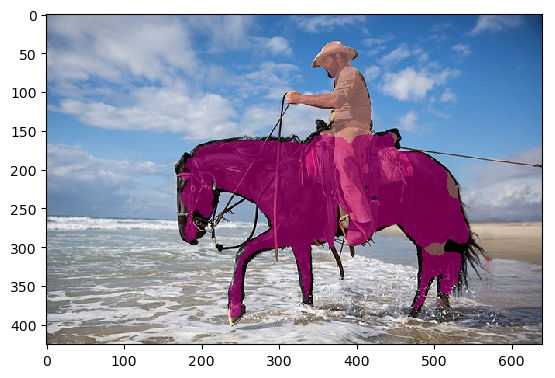

In [10]:
#6. 元の画像を透過させて重ねる
trans_img=Image.new("RGBA",anno_class_img.size,(0,0,0,0))
anno_class_img=anno_class_img.convert("RGBA") #カラーパレット形式をRGBAに変換

for x in range(img_width):
    for y in range(img_height):
        #推論結果画像のピクセルデータを取得
        pixel=anno_class_img.getpixel((x,y))
        r,g,b,a=pixel

        #(0,0,0)の背景ならそのまま透過させる
        if pixel[0]==0 and pixel[1]==0 and pixel[2]==0:
            continue
        else:
            #それ以外の色は用意した画像にピクセルを書き込む
            trans_img.putpixel((x,y),(r,g,b,150))
            #150は透過度の大きさを指定している

img=Image.open(image_file_path) #[高さ][幅][色RGB]
result=Image.alpha_composite(img.convert("RGBA"),trans_img)
plt.imshow(result)
plt.show()